In [2]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Skin Disease Detection/Skin Disease Datasaet/train_set'

# LOAD DATA

In [20]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

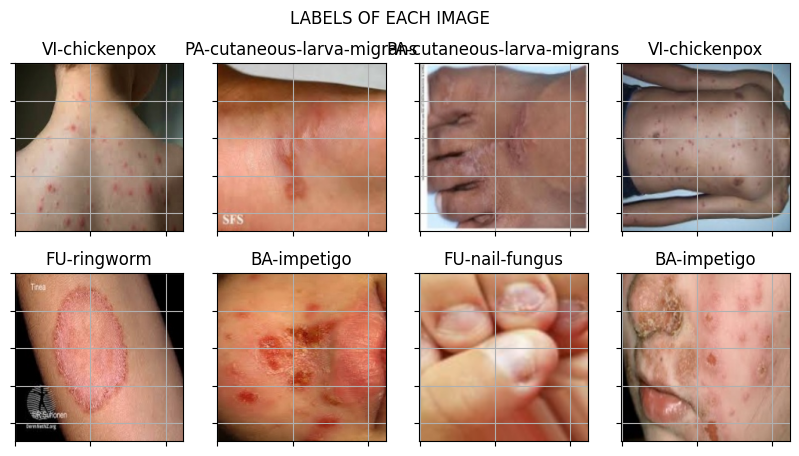

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

# PREPARE MODEL

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [23]:
base_model.trainable = False

In [24]:
num_classes = 8
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [25]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# PREPROCESS DATA

In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [27]:
print(f"X_train: {type(X_train)}, shape: {X_train.shape if X_train is not None else 'None'}")
print(f"y_train_one_hot: {type(y_train_one_hot)}, shape: {y_train_one_hot.shape if y_train_one_hot is not None else 'None'}")


X_train: <class 'numpy.ndarray'>, shape: (738, 224, 224, 3)
y_train_one_hot: <class 'numpy.ndarray'>, shape: (738, 8)


In [28]:
print(f"X_val: {type(X_val)}, shape: {X_val.shape if X_val is not None else 'None'}")
print(f"y_val_one_hot: {type(y_val_one_hot)}, shape: {y_val_one_hot.shape if y_val_one_hot is not None else 'None'}")


X_val: <class 'numpy.ndarray'>, shape: (187, 224, 224, 3)
y_val_one_hot: <class 'numpy.ndarray'>, shape: (187, 8)


# TRAIN

In [29]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 735ms/step - accuracy: 0.5092 - loss: 1.8772 - val_accuracy: 0.9519 - val_loss: 0.1526
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9350 - loss: 0.1883 - val_accuracy: 0.9519 - val_loss: 0.1305
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9888 - loss: 0.0519 - val_accuracy: 0.9626 - val_loss: 0.0938
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.9679 - val_loss: 0.0710
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9842 - loss: 0.0482 - val_accuracy: 0.9840 - val_loss: 0.0508
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.9679 - val_loss: 0.0708
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9679 - val_loss: 0.0808
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9

In [30]:

model.save('/content/drive/MyDrive/Colab Notebooks/Skin Disease Detection/my_model.h5')

In [31]:
model.save('/content/drive/MyDrive/Colab Notebooks/Skin Disease Detection/my_model2.keras')

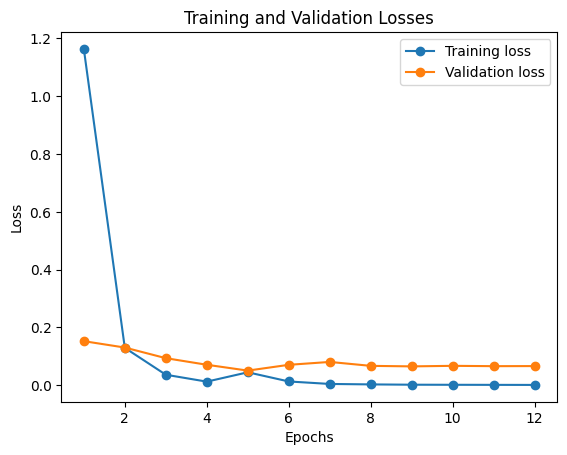

In [32]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

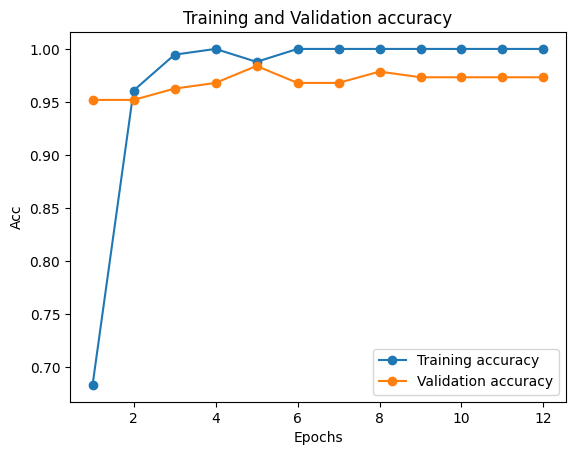

In [33]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

# PREDICT

In [34]:
from tensorflow.keras.models import load_model

In [35]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Skin Disease Detection/Skin Disease Datasaet/test_set'

In [36]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Skin Disease Detection/my_model.h5')

In [37]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

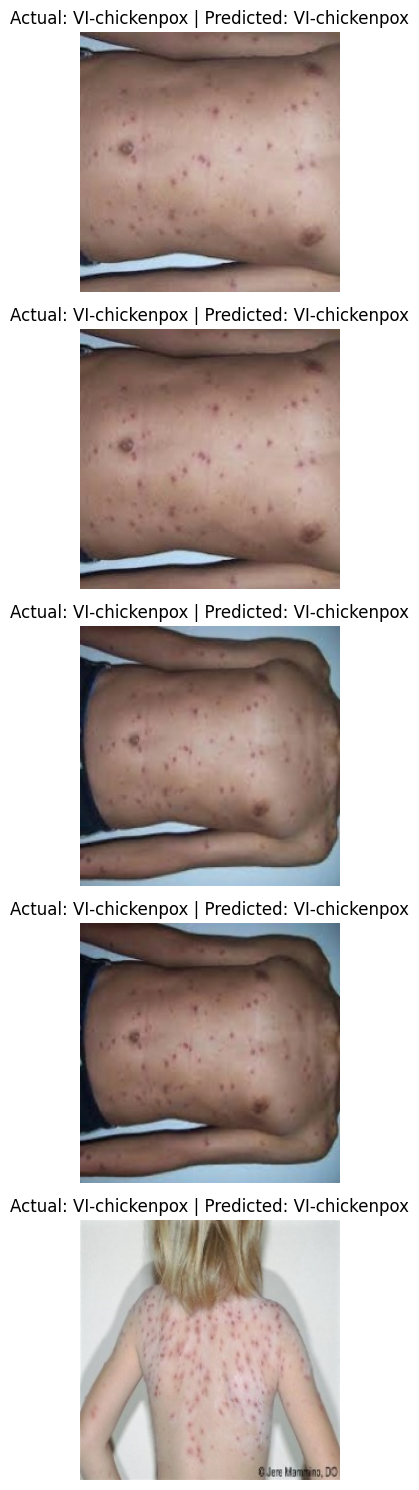

In [39]:

# Initialize lists
real_labels = []
predicted_classes = []
image_files = []

# Process test images
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # Load and preprocess the image
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))  # Resize to the model's expected input size
        img = preprocess_input(np.array([img]))  # Add batch dimension and preprocess

        # Make predictions
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions)

        # Append data
        real_labels.append(folder)  # True label from the folder name
        predicted_classes.append(le.classes_[predicted_class_index])  # Decoded predicted class
        image_files.append(file_path)  # Store the file path for reference

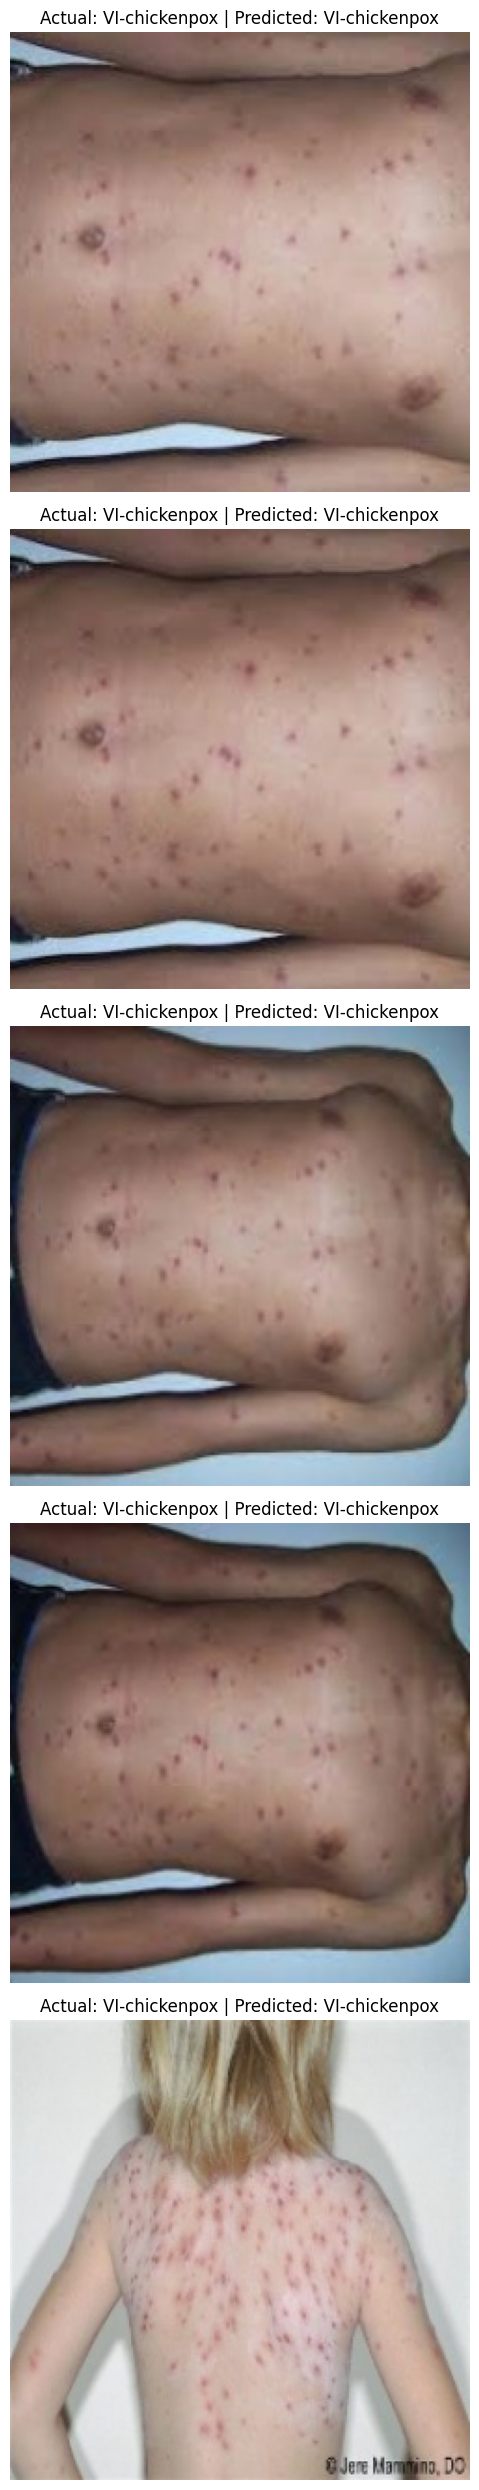

In [40]:

# Display a few results
def display_results(image_files, real_labels, predicted_classes, num_images=5):
    plt.figure(figsize=(15, num_images * 5))

    for i in range(min(num_images, len(image_files))):
        img = cv2.imread(image_files[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color for correct visualization

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual: {real_labels[i]} | Predicted: {predicted_classes[i]}")

    plt.tight_layout()
    plt.show()

# Call the function to visualize results
display_results(image_files, real_labels, predicted_classes, num_images=5)

In [41]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)

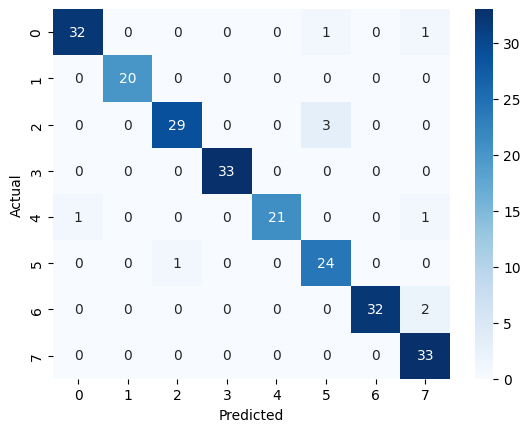

In [42]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()